# Importing the relevant libraries

In [113]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Data Preprocessing

### Importing the Database

In [114]:
df = pd.read_csv("ml_datasource.csv")
print("Shape of dataset: ",df.shape)
print("Columns:",df.columns.tolist())
print("Missing values:\n",df.isnull().sum())
# Preview first 5 rows
df.head()

Shape of dataset:  (17761, 8)
Columns: ['student_country', 'days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_started', 'practice_exams_passed', 'minutes_spent_on_exams', 'purchased']
Missing values:
 student_country           9
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [115]:
# Copy the dataset (to avoid changing the original accidentally)
data = df.copy()

### Removing Outliers

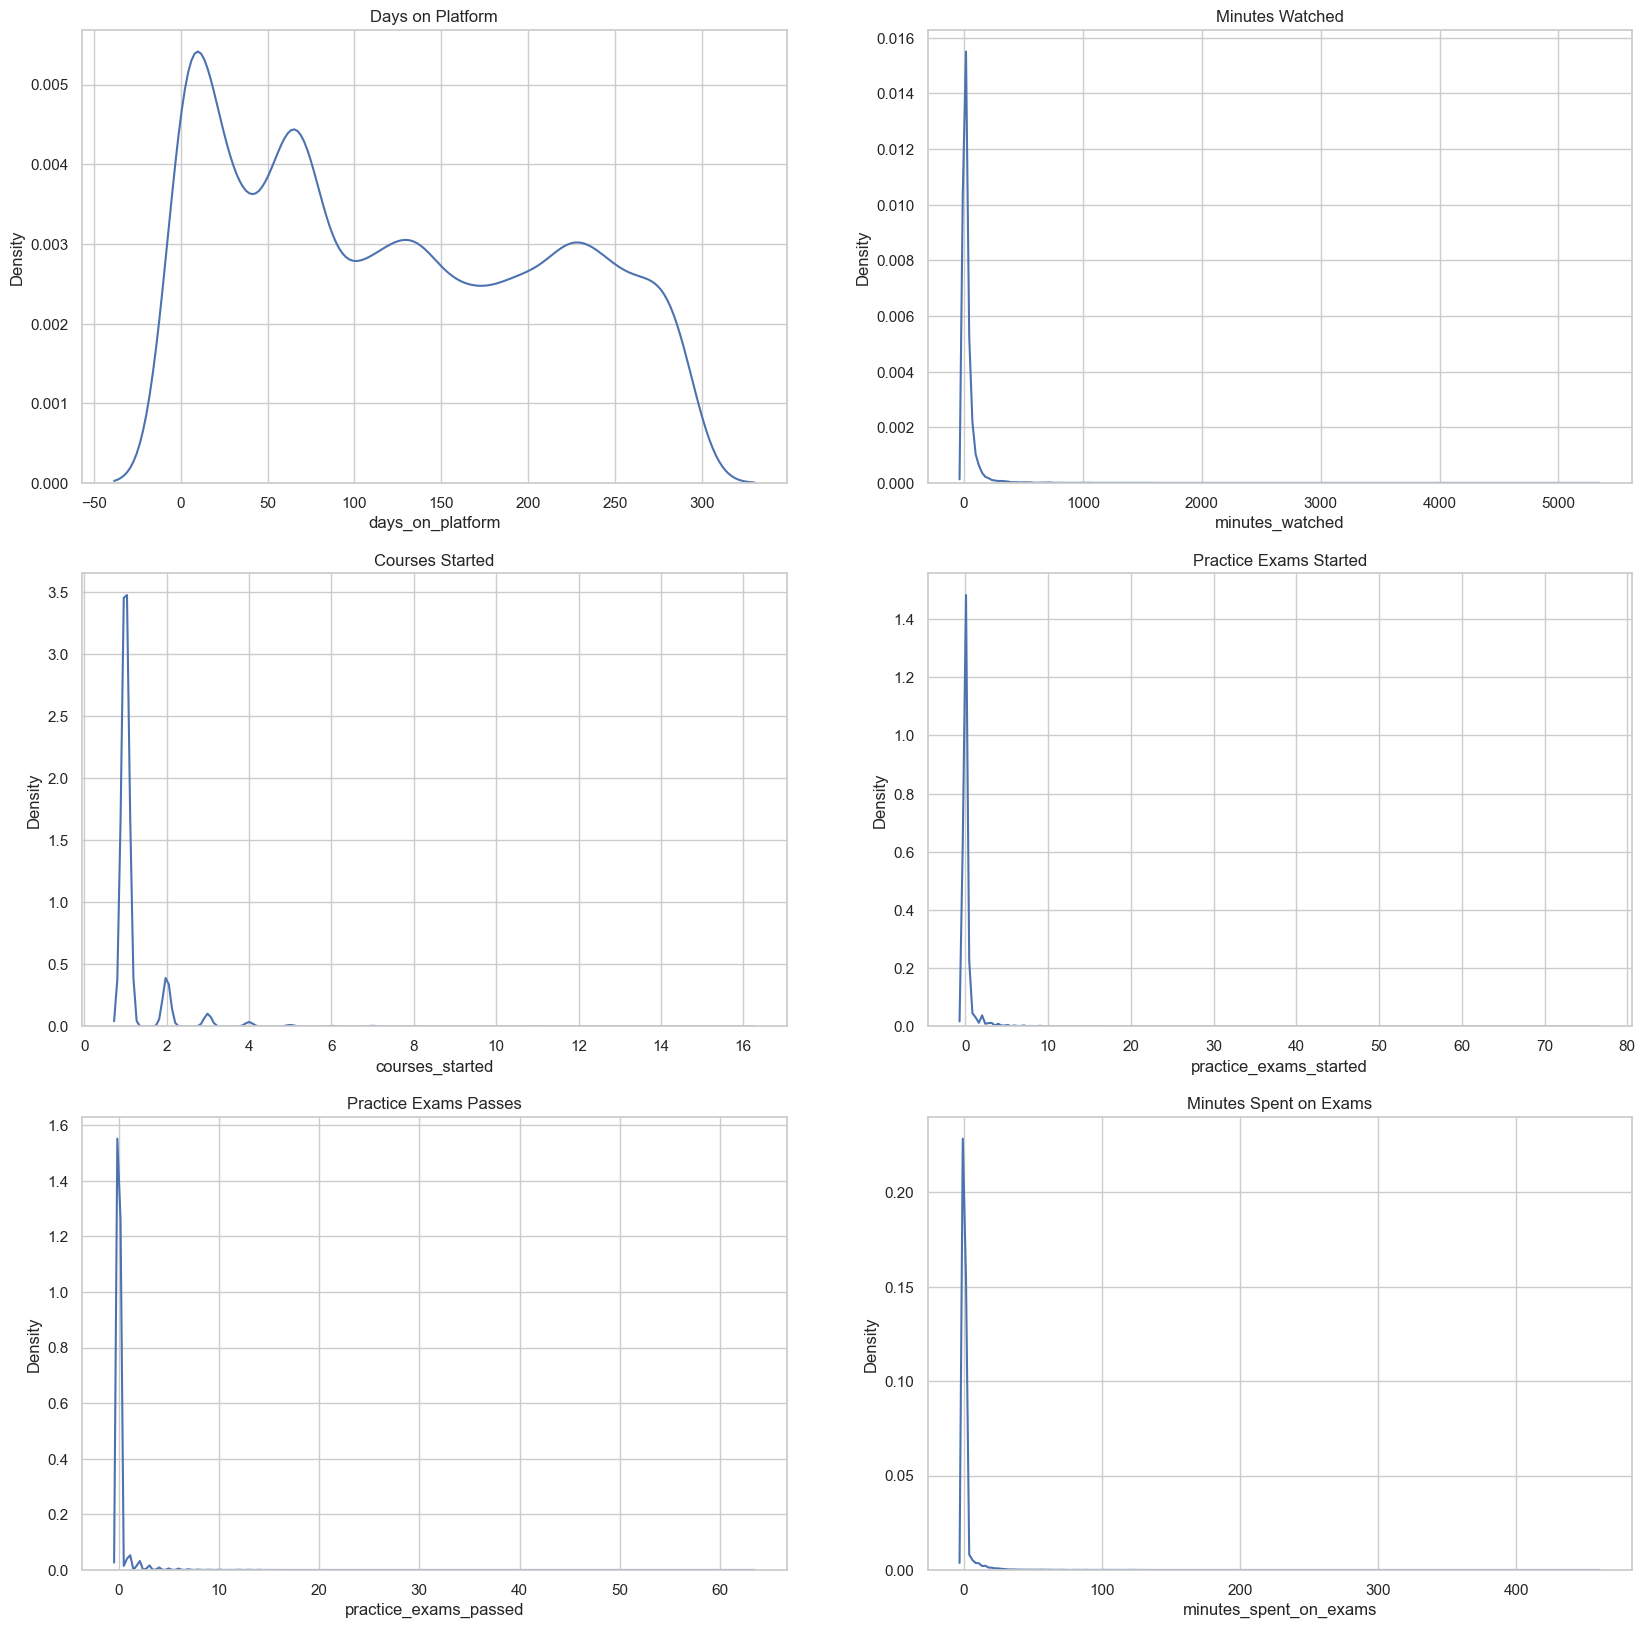

In [116]:
fig, axes = plt.subplots(3,2,figsize=(20,20))
sns.set(style="whitegrid")

sns.kdeplot(data=data['days_on_platform'], ax=axes[0,0])
axes[0,0].set_title("Days on Platform")

sns.kdeplot(data=data['minutes_watched'], ax=axes[0,1])
axes[0,1].set_title("Minutes Watched")

sns.kdeplot(data=data['courses_started'],ax=axes[1,0])
axes[1,0].set_title("Courses Started")

sns.kdeplot(data=data['practice_exams_started'],ax=axes[1,1])
axes[1,1].set_title("Practice Exams Started")

sns.kdeplot(data=data['practice_exams_passed'],ax=axes[2,0])
axes[2,0].set_title("Practice Exams Passes")

sns.kdeplot(data=data['minutes_spent_on_exams'],ax=axes[2,1])
axes[2,1].set_title("Minutes Spent on Exams")

plt.show()


In [117]:

# --- Removing Outliers ---
data_no_outliers = data[
    (data['minutes_watched'] <= 1000) &
    (data['courses_started'] <= 10) &
    (data['practice_exams_started'] <= 10) &
    (data['minutes_spent_on_exams'] <= 40)
]

print("Orginal dataset shape:",data.shape)
print("After removing outliers:",data_no_outliers.shape)

Orginal dataset shape: (17761, 8)
After removing outliers: (17626, 8)


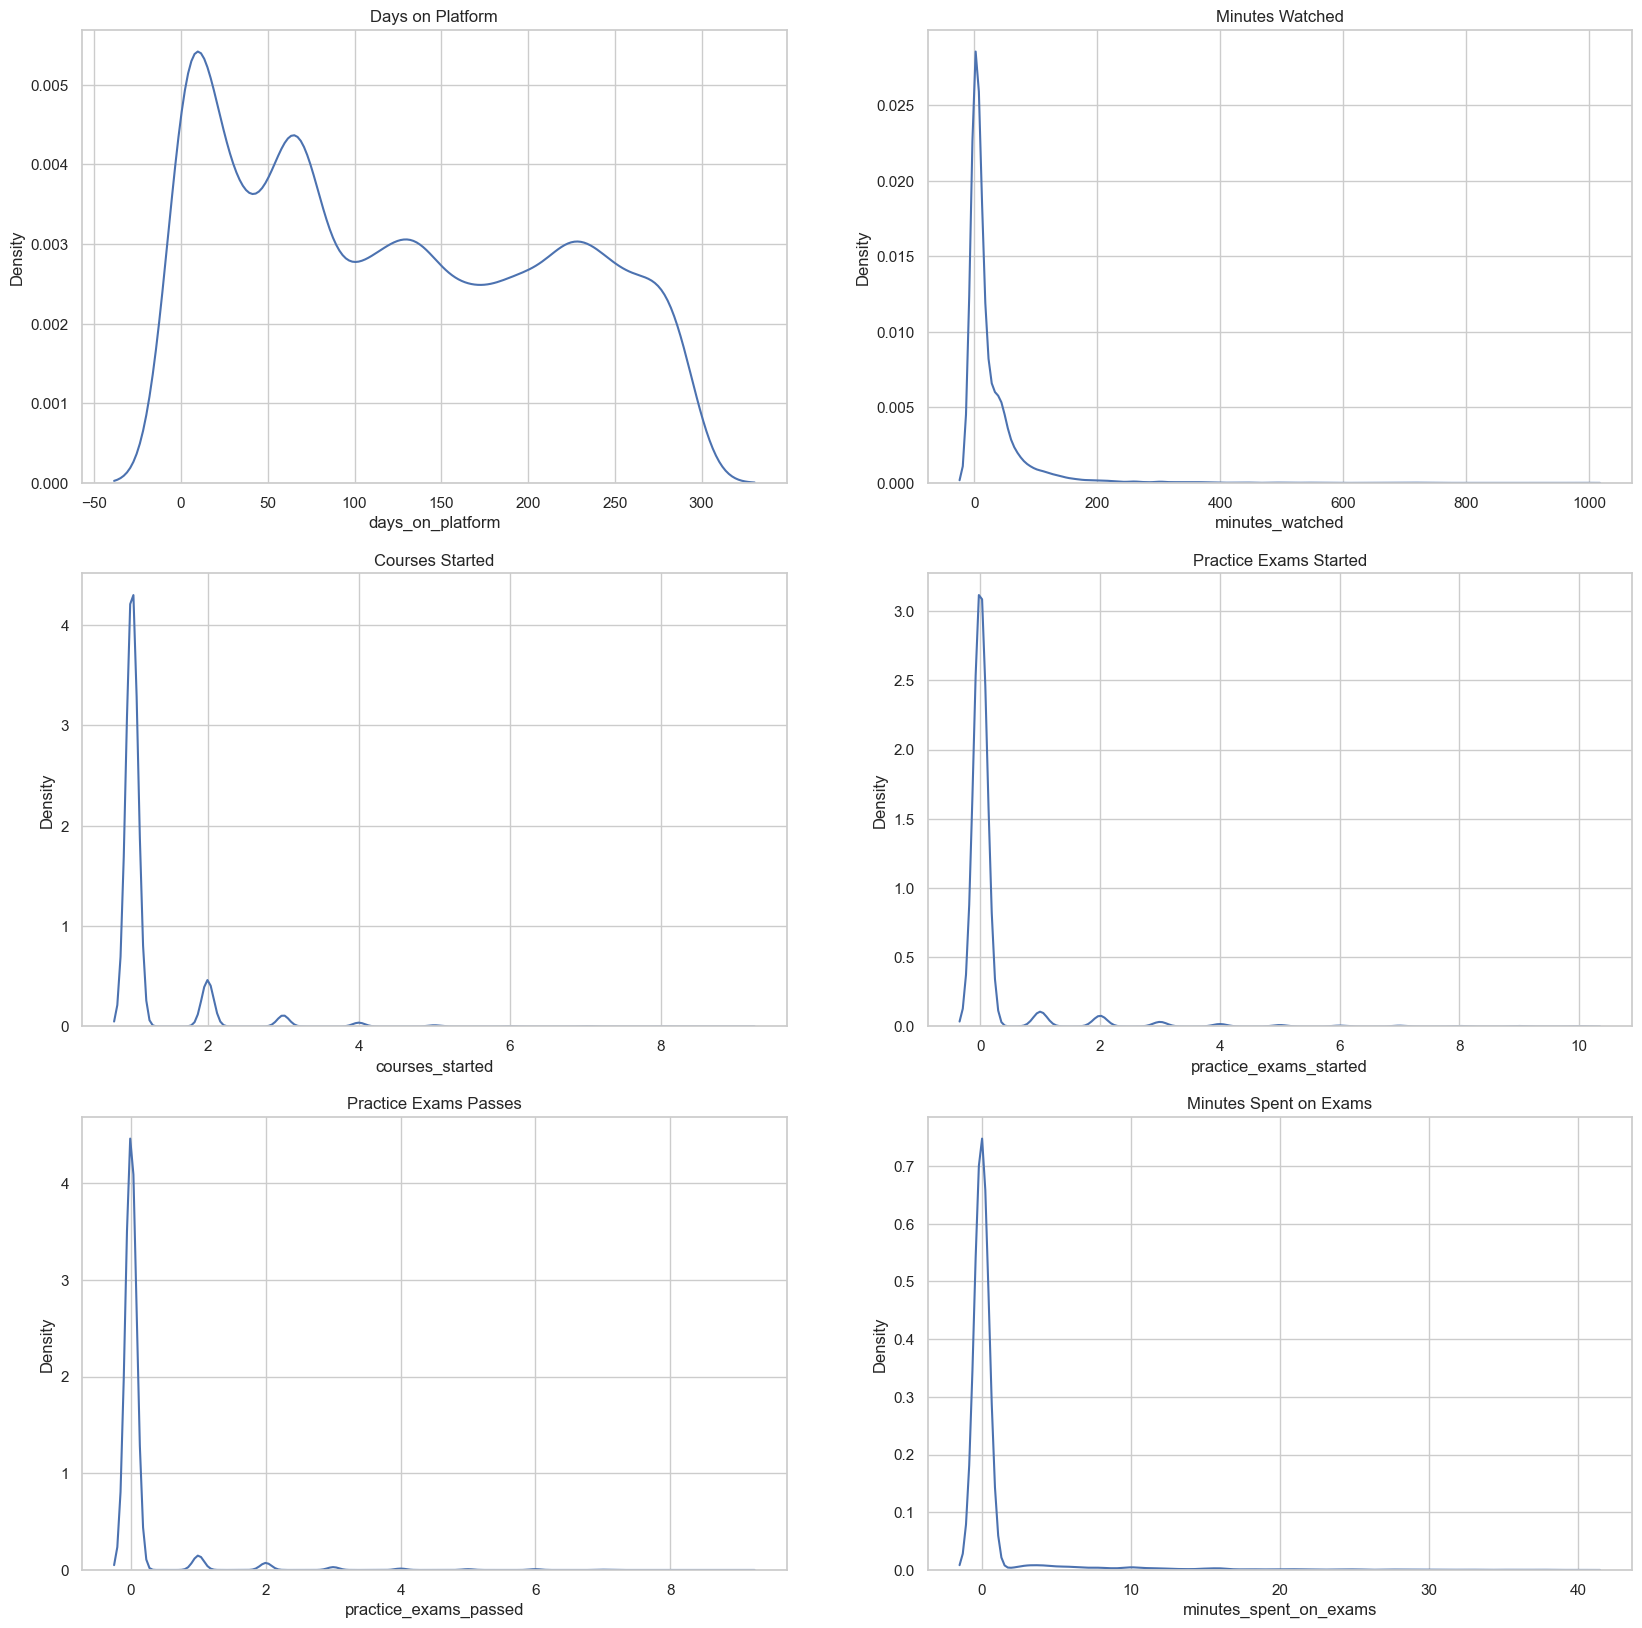

In [119]:
fig, axes = plt.subplots(3,2,figsize=(20,20))
sns.set(style="whitegrid")

sns.kdeplot(data=data_no_outliers['days_on_platform'], ax=axes[0,0])
axes[0,0].set_title("Days on Platform")

sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0,1])
axes[0,1].set_title("Minutes Watched")

sns.kdeplot(data=data_no_outliers['courses_started'],ax=axes[1,0])
axes[1,0].set_title("Courses Started")

sns.kdeplot(data=data_no_outliers['practice_exams_started'],ax=axes[1,1])
axes[1,1].set_title("Practice Exams Started")

sns.kdeplot(data=data_no_outliers['practice_exams_passed'],ax=axes[2,0])
axes[2,0].set_title("Practice Exams Passes")

sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'],ax=axes[2,1])
axes[2,1].set_title("Minutes Spent on Exams")

plt.show()

### Checking for Multicollinearity

In [125]:
## Printing the column names of the dataset
data_no_outliers.columns.to_numpy()

array(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started',
       'practice_exams_passed', 'minutes_spent_on_exams', 'purchased'],
      dtype=object)

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Selecting the numerical columns for Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started', 
                              'practice_exams_started', 
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]
# Calculate VIF for each feature
vif = pd.DataFrame({
    "Feature": variables.columns,
    "VIF":[variance_inflation_factor(variables.to_numpy(),i) for i in range(variables.shape[1])]
})
vif



,Feature,VIF
0,days_on_platform,2.301237
1,minutes_watched,1.788777
2,courses_started,3.178713
3,practice_exams_started,10.201823
4,practice_exams_passed,7.812546
5,minutes_spent_on_exams,3.345478


In [132]:
# Dropping 'practice_exams' to prevent multicollinearity 
data_no_mult = data_no_outliers.drop('practice_exams_started',axis=1)
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [133]:
# Selecting the numerical columns for Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started',  
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]
# Calculate VIF for each feature
vif = pd.DataFrame({
    "Feature": variables.columns,
    "VIF":[variance_inflation_factor(variables.to_numpy(),i) for i in range(variables.shape[1])]
})
vif

,Feature,VIF
0,days_on_platform,2.299940
1,minutes_watched,1.788276
2,courses_started,3.174319
3,practice_exams_passed,2.562412
4,minutes_spent_on_exams,2.602966


### Dealing with NaN Values

In [190]:
data_no_mult.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [191]:
data_no_mult.loc[data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [192]:
data_no_nulls = data_no_mult.copy()
# replace NaNs in the categorical column with 'NAM'
data_no_nulls['student_country'] = data_no_nulls['student_country'].fillna('NAM')
# Displaying records where 'student_country' is 'NAM'
data_no_nulls.loc[data_no_nulls ['student_country']=='NAM','student_country']

311      NAM
337      NAM
556      NAM
806      NAM
1097     NAM
12363    NAM
12633    NAM
16946    NAM
Name: student_country, dtype: object

In [193]:
print(data_no_nulls.isna().sum())

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64


### Splitting the Data

In [194]:
# separate input features (X) and target (Y)
#input
X = data_no_nulls.drop(columns=['purchased'])
#target
y = data_no_nulls['purchased']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,     # 20% of test data
    random_state = 365,  # reproducibility
    stratify = y         # preserve class distribution
)
print("Train set shape:", X_train.shape,y_train.shape)
print("Test set shape:",X_test.shape,y_test.shape)
print("Class distribution in Train:",y_train.value_counts(normalize=True))
print("Class distribution in Train:",y_test.value_counts(normalize=True))
X_train.head()

Train set shape: (14100, 6) (14100,)
Test set shape: (3526, 6) (3526,)
Class distribution in Train: 0    0.907872
1    0.092128
Name: purchased, dtype: float64
Class distribution in Train: 0    0.907828
1    0.092172
Name: purchased, dtype: float64


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
5718,IN,218,1.6,2,0,0.0
3119,IN,263,75.5,1,0,0.0
5440,LK,222,44.4,1,0,0.0
11828,TR,97,2.6,1,0,0.0
8454,KR,162,1.0,1,0,0.0


### Encoding the Data

In [195]:
print(X_train.columns.tolist())   # should include 'student_country'
print(X_test.columns.tolist())

['student_country', 'days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_passed', 'minutes_spent_on_exams']
['student_country', 'days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_passed', 'minutes_spent_on_exams']


In [196]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown = "use_encoded_value",unknown_value=170)

#Fit-transform on encoding training data
X_train['student_country_enc'] = enc.fit_transform(
    #selects the column with country names and converts it into a 2D array.
    X_train['student_country'].to_numpy().reshape(-1,1)
)

#Transform on encoding test data

#Only .transform() here (not .fit_transform()), 
#because we must use the same mapping learned from training data.
X_test['student_country_enc'] = enc.transform(
    X_test['student_country'].to_numpy().reshape(-1,1)
)

# Dropping the original 'student_country' column after encoding
X_train = X_train.drop(columns=['student_country'])
X_test = X_test.drop(columns=['student_country'])

#Convert to NumPy arrays
X_train_array = np.asarray(X_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

X_test_array = np.asarray(X_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

X_train.head()


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0.0,69.0
3119,263,75.5,1,0,0.0,69.0
5440,222,44.4,1,0,0.0,84.0
11828,97,2.6,1,0,0.0,148.0
8454,162,1.0,1,0,0.0,80.0


In [197]:
# --- Check results ---
print("x_train_array shape:", X_train_array.shape)
print("y_train_array shape:", y_train_array.shape)
print("x_test_array shape:", X_test_array.shape)
print("y_test_array shape:", y_test_array.shape)

x_train_array shape: (14100, 6)
y_train_array shape: (14100,)
x_test_array shape: (3526, 6)
y_test_array shape: (3526,)


# Creating a Logistic Regression Model

Optimization terminated successfully.
         Current function value: 0.153146
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:                  0.5019
Time:                        19:53:54   Log-Likelihood:                -2159.4
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.914      0.000      -0.073      -0.065
x2             0.0144      0

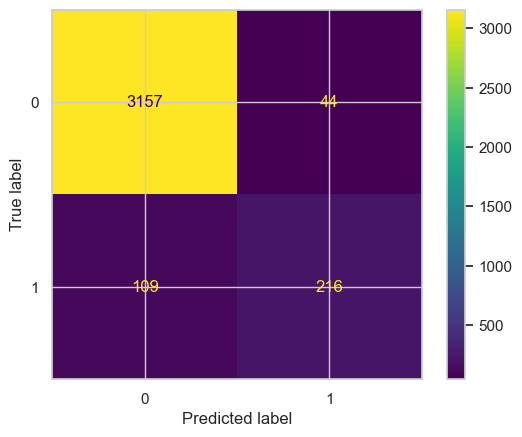


Classification report:
              precision    recall  f1-score   support

           0      0.967     0.986     0.976      3201
           1      0.831     0.665     0.738       325

    accuracy                          0.957      3526
   macro avg      0.899     0.825     0.857      3526
weighted avg      0.954     0.957     0.954      3526

ROC-AUC: 0.8254348400740154


In [202]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

#buils the logit model (add an intercept)
log_reg = sm.Logit(y_train_array,X_train_array)
#fit
log_res_results = log_reg.fit()

#summary
print(log_res_results.summary())
#Predict probabilities on the test set
y_prob = log_res_results.predict(X_test_array)
#Convert probabilities to class labels (threshold 0.5), like the main solution
y_test_pred_log_res = (y_prob > 0.5).astype(int)

#confussion matrix
ConfusionMatrixDisplay.from_predictions(y_test_array,y_test_pred_log_res)
plt.show()

print("\nClassification report:")
print(classification_report(y_test_array, y_test_pred_log_res, digits=3))

print("ROC-AUC:", roc_auc_score(y_test_array, y_test_pred_log_res))

# Creating a K-Nearest Neighbors Model

Best params: {'n_neighbors': 10, 'weights': 'distance'}
CV best accuracy: 0.9598581560283688


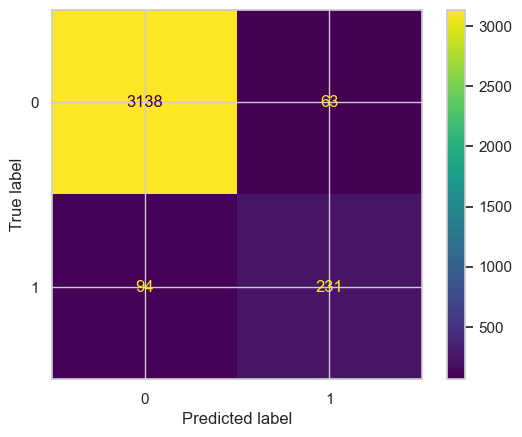

              precision    recall  f1-score   support

    Free (0)       0.97      0.98      0.98      3201
     Paid(1)       0.79      0.71      0.75       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.86      3526
weighted avg       0.95      0.96      0.95      3526



In [208]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#defining the range of parameters  want to tune

prameters_knn = {
    "n_neighbors": list(range(1,51)),
    # majority vote vs distance-weighted
    "weights": ["uniform","distance"]
}

#  pipeline: scale -> KNN
#pipe = Pipeline([
    #("scaler",StandardScaler()),
   # ("knn",KNeighborsClassifier())
#])

#grid search
grid_search_knn = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid =  prameters_knn,
    scoring = "accuracy",
)

#fit on training data
grid_search_knn.fit(X_train_array, y_train_array)
#best model
knn_clf = grid_search_knn.best_estimator_
print("Best params:", grid_search_knn.best_params_)
print("CV best accuracy:", grid_search_knn.best_score_)
#predict on test data
y_test_pred_knn = knn_clf.predict(X_test_array)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_array,y_test_pred_knn,labels = knn_clf.classes_)
plt.show()

print(classification_report(y_test_array,y_test_pred_knn,target_names=["Free (0)","Paid(1)"]))

# Creating a Support Vector Machines Model

Best params: {'C': 8, 'gamma': 'scale', 'kernel': 'poly'}
CV best accuracy: 0.9607092198581562


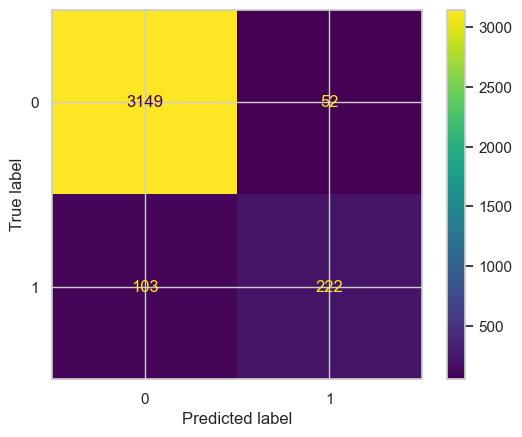

              precision    recall  f1-score   support

     Free(0)       0.97      0.98      0.98      3201
     Paid(1)       0.81      0.68      0.74       325

    accuracy                           0.96      3526
   macro avg       0.89      0.83      0.86      3526
weighted avg       0.95      0.96      0.95      3526



In [211]:
from sklearn.preprocessing import MinMaxScaler

#scaler feature between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)

#define parameter grid
parameters_svm = {
    "kernel": ["linear","poly","rbf"],
    "C": list(range(1,11)),
    "gamma": ["scale","auto"]
}
#Grid search with SVM
grid_search_svm = GridSearchCV(
    estimator = SVC(),
    param_grid =  parameters_svm,
    scoring = "accuracy",
)
#fit model
grid_search_svm.fit(X_train_scaled,y_train_array)

#best model
svm_clf = grid_search_svm.best_estimator_
print("Best params:", grid_search_svm.best_params_)
print("CV best accuracy:", grid_search_svm.best_score_)
#predict on test data
y_test_pred_svm = svm_clf.predict(X_test_scaled)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_array,y_test_pred_svm,labels = svm_clf.classes_)
plt.show()

#print classification report
print(classification_report(y_test_array,y_test_pred_svm,target_names=["Free(0)","Paid(1)"]))

# Creating a Decision Trees Model

Best params: {'ccp_alpha': 0.001}
CV best accuracy: 0.960921985815603


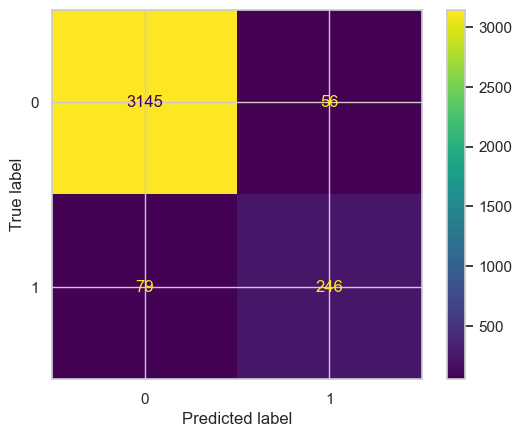

              precision    recall  f1-score   support

    Free (0)       0.98      0.98      0.98      3201
    Paid (1)       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



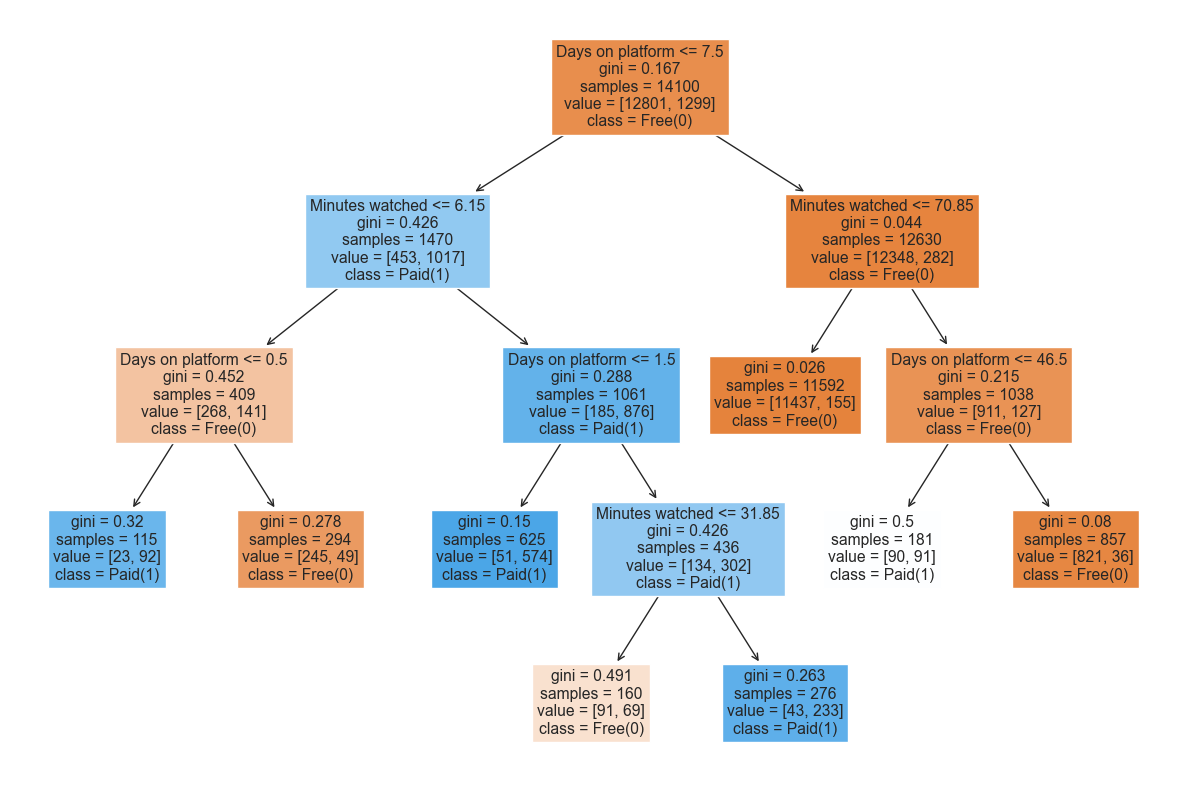

In [214]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Grid of ccp_alpha values only
param_grid_dt = {
    "ccp_alpha": [0,0.001,0.002,0.003,0.004,0.005]
}
# GridSearchCV over DecisionTreeClassifier
grid_dt = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=365),
    param_grid = param_grid_dt,
    scoring = "accuracy",
)
# Fit a GridSearchCV object on the training data
grid_dt.fit(X_train_array,y_train_array)
#best model & its cv accuracy
dt_clf = grid_dt.best_estimator_
print("Best params:", grid_dt.best_params_)
print("CV best accuracy:", grid_dt.best_score_)
#predict on test data
y_pred_dt = dt_clf.predict(X_test_array)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_array,y_pred_dt,labels = dt_clf.classes_)
plt.show()
# Classification report
print(classification_report(y_test, y_pred_dt, target_names=["Free (0)", "Paid (1)"]))
#plot the tree
plt.figure(figsize=(15,10))
plot_tree(
    dt_clf,
    filled = True,
    feature_names = ['Days on platform', 
                           'Minutes watched', 
                           'Courses started',
                           'Practice exams passed', 
                           'Time spent on exams', 
                           'Student country encoded'],
    class_names=["Free(0)","Paid(1)"],
)
plt.show()

# Creating a Random Forests Model

Best alpha from Decision Tree: 0.001


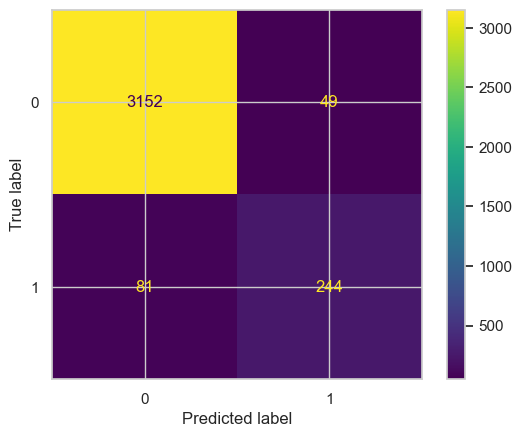

              precision    recall  f1-score   support

     Free(0)       0.97      0.98      0.98      3201
     Paid(1)       0.83      0.75      0.79       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



In [215]:
# Get best alpha from Decision Tree GridSearch
best_alpha = grid_dt.best_params_["ccp_alpha"]
print("Best alpha from Decision Tree:", best_alpha)

# create random forest with the best ccp_alpha from Decision Tree
rf = RandomForestClassifier(ccp_alpha = best_alpha, random_state=365)
# fit the model
rf.fit(X_train_array,y_train_array)
#predict model
y_pred_rf = rf.predict(X_test_array)
#confusion_matrix
ConfusionMatrixDisplay.from_predictions(y_test_array,y_pred_rf,labels = rf.classes_)
plt.show()

# classification report
print(classification_report(y_test, y_pred_rf, target_names=["Free(0)", "Paid(1)"]))

In [217]:
from sklearn.ensemble import VotingClassifier

# Assume these are your trained models:
# log_reg_clf, knn_clf, dt_clf, svm_clf, rf_clf
# (all trained on the same X_train, y_train)

voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_res_results),
        ('knn', knn_clf),
        ('dt', dt_clf),
        ('svm', svm_clf),
        ('rf', rf)
    ],
    voting='soft'   # 'hard' = majority vote, 'soft' = average of probabilities
)

# Fit the voting model
voting_clf.fit(X_train_array, y_train_array)


ValueError: The estimator BinaryResultsWrapper should be a classifier.